## 作业描述：

### ✓代码跑通

请大家根据课上所学内容，在 MyDNN类中补全代码，构造DNN网络，保证程序跑通。

### ✓调优

思考并动手进行调优，以在验证集上的准确率为评价指标，验证集上准确率越高，得分越高！

# **任务描述：**

### 本次实践是一个多分类任务，需要将照片中的宝石分别进行识别，完成**宝石的识别**

### **实践平台：百度AI实训平台-AI Studio、PaddlePaddle1.8.0 动态图**


![](https://ai-studio-static-online.cdn.bcebos.com/7640d4434f894f5dbae1d85c62e54b8476e24856aabc4c5f9915fea1b26f3ebc)


# 深度神经网络(DNN)

### **深度神经网络（Deep Neural Networks，简称DNN）是深度学习的基础，其结构为input、hidden（可有多层）、output，每层均为全连接。**
![](https://ai-studio-static-online.cdn.bcebos.com/c60fc28848cf469fa3a7824aa637a03f3b2b213ce7b84659919cb24b4430bffb)



# 数据集介绍

* **数据集文件名为archive_train.zip,archive_test.zip。**

* **该数据集包含25个类别不同宝石的图像。**

* **这些类别已经分为训练和测试数据。**

* **图像大小不一，格式为.jpeg。**


![](https://ai-studio-static-online.cdn.bcebos.com/7640d4434f894f5dbae1d85c62e54b8476e24856aabc4c5f9915fea1b26f3ebc)


In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data55032


In [1]:
#导入需要的包
import os
import zipfile
import random
import json
import cv2
import numpy as np
from PIL import Image
import paddle
import paddle.fluid as fluid
from paddle.fluid.dygraph import Linear
import matplotlib.pyplot as plt

2022-11-13 21:10:46,066-INFO: font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
2022-11-13 21:10:46,459-INFO: generated new fontManager


# 1、数据准备

In [13]:

'''
参数配置
'''
train_parameters = {
    "input_size": [3, 224, 224],                           #输入图片的shape
    "class_dim": -1,                                     #分类数
    "src_path":"data/data55032/archive_train.zip",       #原始数据集路径
    "target_path":"/home/aistudio/data/dataset",        #要解压的路径 
    "train_list_path": "./train_data.txt",              #train_data.txt路径
    "eval_list_path": "./val_data.txt",                  #eval_data.txt路径
    "label_dict":{},                                    #标签字典
    "readme_path": "/home/aistudio/data/readme.json",   #readme.json路径
    "num_epochs": 10,                                    #训练轮数
    "train_batch_size": 6,                             #批次的大小
    "learning_strategy": {                              #优化函数相关的配置
        "lr": 0.0005                                     #超参数学习率
    } 
}

In [ ]:
def unzip_data(src_path,target_path):

    '''
    解压原始数据集，将src_path路径下的zip包解压至data/dataset目录下
    '''

    if(not os.path.isdir(target_path)):    
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()
    else:
        print("文件已解压")


In [ ]:

def get_data_list(target_path,train_list_path,eval_list_path):
    '''
    生成数据列表
    '''
    #存放所有类别的信息
    class_detail = []
    #获取所有类别保存的文件夹名称
    data_list_path=target_path
    class_dirs = os.listdir(data_list_path)
    if '__MACOSX' in class_dirs:
        class_dirs.remove('__MACOSX')
    # #总的图像数量
    all_class_images = 0
    # #存放类别标签
    class_label=0
    # #存放类别数目
    class_dim = 0
    # #存储要写进eval.txt和train.txt中的内容
    trainer_list=[]
    eval_list=[]
    #读取每个类别
    for class_dir in class_dirs:
        if class_dir != ".DS_Store":
            class_dim += 1
            #每个类别的信息
            class_detail_list = {}
            eval_sum = 0
            trainer_sum = 0
            #统计每个类别有多少张图片
            class_sum = 0
            #获取类别路径 
            path = os.path.join(data_list_path,class_dir)
            # print(path)
            # 获取所有图片
            img_paths = os.listdir(path)
            for img_path in img_paths:                                  # 遍历文件夹下的每个图片
                if img_path =='.DS_Store':
                    continue
                name_path = os.path.join(path,img_path)                       # 每张图片的路径
                if class_sum % 15 == 0:                                 # 每10张图片取一个做验证数据
                    eval_sum += 1                                       # eval_sum为测试数据的数目
                    eval_list.append(name_path + "\t%d" % class_label + "\n")
                else:
                    trainer_sum += 1 
                    trainer_list.append(name_path + "\t%d" % class_label + "\n")#trainer_sum测试数据的数目
                class_sum += 1                                          #每类图片的数目
                all_class_images += 1                                   #所有类图片的数目
            
            # 说明的json文件的class_detail数据
            class_detail_list['class_name'] = class_dir             #类别名称
            class_detail_list['class_label'] = class_label          #类别标签
            class_detail_list['class_eval_images'] = eval_sum       #该类数据的测试集数目
            class_detail_list['class_trainer_images'] = trainer_sum #该类数据的训练集数目
            class_detail.append(class_detail_list)  
            #初始化标签列表
            train_parameters['label_dict'][str(class_label)] = class_dir
            class_label += 1
            
    #初始化分类数
    train_parameters['class_dim'] = class_dim
    print(train_parameters)
    #乱序  
    random.shuffle(eval_list)
    with open(eval_list_path, 'a') as f:
        for eval_image in eval_list:
            f.write(eval_image) 
    #乱序        
    random.shuffle(trainer_list) 
    with open(train_list_path, 'a') as f2:
        for train_image in trainer_list:
            f2.write(train_image) 

    # 说明的json文件信息
    readjson = {}
    readjson['all_class_name'] = data_list_path                  #文件父目录
    readjson['all_class_images'] = all_class_images
    readjson['class_detail'] = class_detail
    jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
    with open(train_parameters['readme_path'],'w') as f:
        f.write(jsons)
    print ('生成数据列表完成！')

In [ ]:
def data_reader(file_list):
    '''
    自定义data_reader
    '''
    def reader():
        with open(file_list, 'r') as f:
            lines = [line.strip() for line in f]
            for line in lines:
                img_path, lab = line.strip().split('\t')
                img = Image.open(img_path) 
                if img.mode != 'RGB': 
                    img = img.convert('RGB') 
                img = img.resize((224, 224), Image.BILINEAR)
                img = np.array(img).astype('float32') 
                img = img.transpose((2, 0, 1))  # HWC to CHW 
                img = img/255                   # 像素值归一化 
                yield img, int(lab) 
    return reader

In [ ]:
from PIL import Image
def add_by_pil_rotation(target_path):    
    data_list_path=target_path
    class_dirs = os.listdir(data_list_path)    
    #读取每个类别
    for class_dir in class_dirs:
        if class_dir != "__MACOSX":           
            path = os.path.join(data_list_path,class_dir)            
            img_paths = os.listdir(path)
            for img_path in img_paths:                                  # 遍历文件夹下的每个图片
                if img_path =='.DS_Store':
                    continue
                name_path = os.path.join(path,img_path)
                Image.open(name_path).convert('RGB').rotate(45).save(os.path.join(path,'new45_'+img_path))
                Image.open(name_path).convert('RGB').rotate(135).save(os.path.join(path,'new135_'+img_path))
                Image.open(name_path).convert('RGB').transpose(Image.FLIP_LEFT_RIGHT).save(os.path.join(path,'left_'+img_path))
                Image.open(name_path).convert('RGB').transpose(Image.FLIP_TOP_BOTTOM).save(os.path.join(path,'up_'+img_path))
                

In [ ]:
!pip install imgaug

Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 952kB 15.6MB/s eta 0:00:01
     |████████████████████████████████| 12.5MB 8.4MB/s eta 0:00:011
     |████████████████████████████████| 1.0MB 12.9MB/s eta 0:00:01
     |████████████████████████████████| 4.4MB 17.5MB/s eta 0:00:01
     |████████████████████████████████| 163kB 23.4MB/s eta 0:00:01


2020-12-14 17:47:43,648-WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


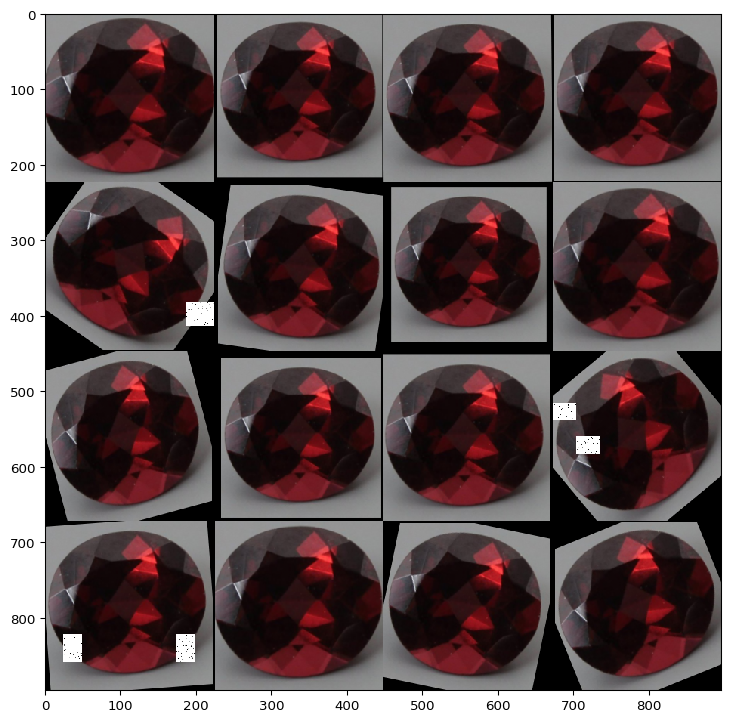

In [ ]:
import imgaug as ia
from imgaug import augmenters as iaa
sometimes = lambda aug: iaa.Sometimes(0.1, aug)

ia.seed(1)
'''
seq = iaa.Sequential([
    #iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.2), # horizontally flip 50% of the images
    iaa.Flipud(0.2),   
    sometimes(iaa.CropAndPad(
         percent=(-0.01, 0.01),
         pad_mode=ia.ALL,
         pad_cval=(0, 1)
    )),
    sometimes(iaa.Affine(scale=(0.9, 1.1))),
    #iaa.CoarseSaltAndPepper(0.05, size_percent=(0.01, 0.1)),#size_px
    iaa.Sometimes(
        0.5,
        iaa.CoarseSaltAndPepper(0.01, size_percent=(0.01, 0.05)),
        #iaa.Pepper(0.01),
    ),    
], random_order=True)
'''
seq = iaa.Sequential([
    #iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.2), # horizontally flip 50% of the images
    iaa.Flipud(0.2),   
    sometimes(iaa.CropAndPad(
         percent=(-0.01, 0.01),
         pad_mode=ia.ALL,
         pad_cval=(0, 1)
    )),
    #sometimes(iaa.Affine(scale=(0.9, 1.1))),
    #iaa.CoarseSaltAndPepper(0.05, size_percent=(0.01, 0.1)),#size_px
    iaa.Sometimes(0.5,iaa.CoarseSalt(0.01, size_percent=(0.01, 0.05))),    
    iaa.Sometimes(0.5,iaa.Pepper(0.01)),
    iaa.CenterPadToFixedSize(width=40, height=40),
    iaa.CropToFixedSize(width=32, height=32)
], random_order=False)

seq = iaa.Sequential([
    iaa.Sometimes(1,iaa.OneOf([ 
    iaa.Affine(scale=(0.9, 1.1)),
    iaa.Affine(rotate=(-45, 45)),
    iaa.Affine(shear=(-16, 16)),
    ])),
    iaa.Sometimes(0.3,iaa.CoarseSaltAndPepper(0.01, size_percent=(0.01, 0.05))),   
    iaa.PadToFixedSize(width=230, height=230),
    iaa.CropToFixedSize(width=224, height=224)
])
img_data=load_image('data/dataset/Almandine/almandine_31.jpg')
seq.show_grid(np.transpose(img_data,(1,2,0)),cols=4,rows=4)

In [54]:
batch_size

6

In [53]:
'''
参数初始化
'''
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']
batch_size=train_parameters['train_batch_size']
'''
解压原始数据到指定路径
'''
!rm -rf /home/aistudio/data/dataset
unzip_data(src_path,target_path)
#for i in range(3):add_by_pil_rotation(target_path)

#每次生成数据列表前，首先清空train.txt和eval.txt
# with open(train_list_path, 'w') as f: 
#     f.seek(0)
#     f.truncate() 
# with open(eval_list_path, 'w') as f: 
#     f.seek(0)
#     f.truncate() 
    
#生成数据列表   
# get_data_list(target_path,train_list_path,eval_list_path)

'''
构造数据提供器
'''
train_reader = paddle.batch(data_reader(train_list_path),
                            batch_size=batch_size,
                            drop_last=True)
eval_reader = paddle.batch(data_reader(eval_list_path),
                            batch_size=batch_size,
                            drop_last=True)
                            

In [ ]:
Batch=0
Batchs=[]
all_train_accs=[]
def draw_train_acc(Batchs, train_accs):
    title="training accs"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("acc", fontsize=14)
    plt.plot(Batchs, train_accs, color='green', label='training accs')
    plt.legend()
    plt.grid()
    plt.show()

all_train_loss=[]
def draw_train_loss(Batchs, train_loss):
    title="training loss"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.plot(Batchs, train_loss, color='red', label='training loss')
    plt.legend()
    plt.grid()
    plt.show()

# 2、定义模型

### ###在以下cell中完成DNN网络的定义###

In [ ]:
#定义DNN网络
class MyDNN(fluid.dygraph.Layer):
    '''
    DNN网络
    '''
    
    def __init__(self):
        super(MyDNN,self).__init__()
        self.hidden1=Linear(3*224*224,1000,act='relu')
        self.hidden2=Linear(1000,500,act='relu')
        self.hidden3=Linear(500,100,act='relu')
        self.out=Linear(100,25,act='softmax')
        # 初始化
    def forward(self,input):        
        # forward 定义执行实际运行时网络的执行逻辑
        x=fluid.layers.reshape(input,shape=[-1,3*224*224])
        x=self.hidden1(x)
        x=self.hidden2(x)
        x=self.hidden3(x)
        y=self.out(x)
        return y

       

# 3、训练模型

0.6060606


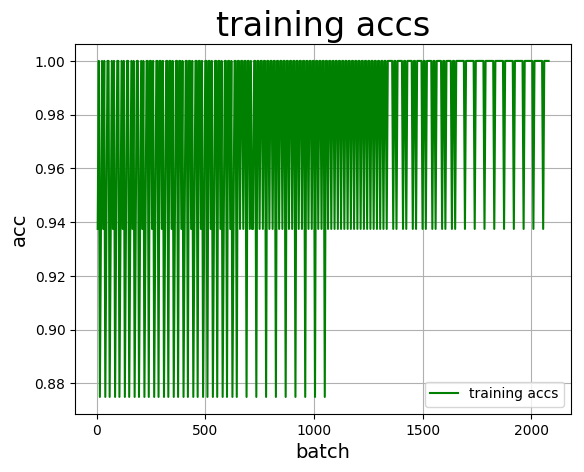

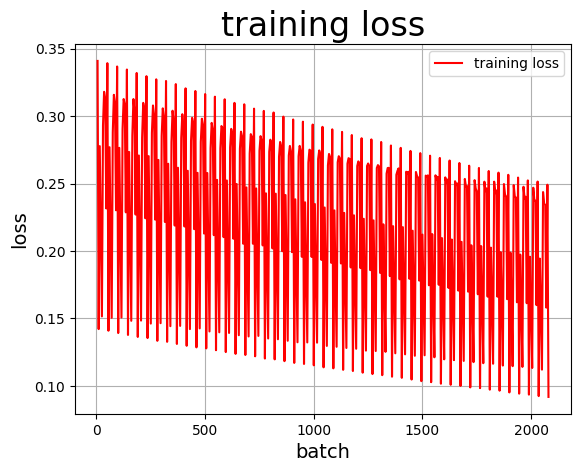

In [55]:
with fluid.dygraph.guard(fluid.CUDAPlace(0)):
    model=MyDNN() #模型实例化
    model_dict, _ = fluid.load_dygraph('MyDNN')    
    model.load_dict(model_dict) #加载模型参数
    model.train() #训练模式
    opt=fluid.optimizer.SGDOptimizer(learning_rate=train_parameters['learning_strategy']['lr'], parameter_list=model.parameters())#优化器选用SGD随机梯度下降，学习率为0.001.
    epochs_num=train_parameters['num_epochs'] #迭代次数
    best_avg_acc=0.71875
    res={}
    for pass_num in range(80):        
        if pass_num>0:break
        model.train()
        for batch_id,data in enumerate(train_reader()):
            if batch_id>0:break
            images = np.array([x[0] for x in data]).astype('float32').reshape(-1, 3,224,224)
            #print(images.shape) # (16, 3, 224, 224)
            labels = np.array([x[1] for x in data]).astype('int64')
            labels = labels[:, np.newaxis]

            #images=np.transpose(images,(0,2,3,1))
            #images = seq(images=images)
            #images=np.transpose(images,(0,3,1,2))

            image=fluid.dygraph.to_variable(images)
            label=fluid.dygraph.to_variable(labels)

            predict=model(image) #数据传入model
            
            loss=fluid.layers.cross_entropy(predict,label)
            avg_loss=fluid.layers.mean(loss)#获取loss值
            
            acc=fluid.layers.accuracy(predict,label)#计算精度
            res['out']=predict
            res['label']=label
            res['acc']=acc
            res['loss']=loss
            res['avg_loss']=avg_loss
            if batch_id!=0 and batch_id%5==0:
                Batch = Batch+5 
                Batchs.append(Batch)
                all_train_loss.append(avg_loss.numpy()[0])
                all_train_accs.append(acc.numpy()[0])
                
                print("epoch:{},batch_id:{},train_loss:{},train_acc:{}".format(pass_num,batch_id,avg_loss.numpy(),acc.numpy()))
            
            avg_loss.backward()       
            opt.minimize(avg_loss)    #优化器对象的minimize方法对参数进行更新 
            model.clear_gradients()   #model.clear_gradients()来重置梯度

        accs = []       
        model.eval() #训练模式
        for batch_id,data in enumerate(eval_reader()):#测试集
            images = np.array([x[0] for x in data]).astype('float32').reshape(-1, 3,224,224)
            labels = np.array([x[1] for x in data]).astype('int64')
            labels = labels[:, np.newaxis]
            image=fluid.dygraph.to_variable(images)
            label=fluid.dygraph.to_variable(labels)       
            predict=model(image)       
            acc=fluid.layers.accuracy(predict,label)
            accs.append(acc.numpy()[0])
            avg_acc = np.mean(accs)
        print(avg_acc)
        if avg_acc>best_avg_acc:
            print("best model,save")
            fluid.save_dygraph(model.state_dict(),'MyDNN-best')#保存模型
            best_avg_acc=avg_acc

    fluid.save_dygraph(model.state_dict(),'MyDNN')#保存模型

draw_train_acc(Batchs,all_train_accs)
draw_train_loss(Batchs,all_train_loss)

## 自己计算loss
out、label、acc、loss、avg_loss

In [56]:
for key in res:
    res[key]=res[key].numpy()
np.savez('自己计算loss.npz',**res)

In [2]:
import numpy as np
_res=np.load('自己计算loss.npz')


In [5]:
res={}
for key in _res:
  res[key]=np.array(_res[key])#fluid.dygraph.to_variable(_res[key]).numpy()

In [6]:
print(res['out'][:3,:5])

[[5.3990648e-09 5.5443099e-09 6.6981578e-05 6.9977430e-04 7.5791286e-05]
 [6.3566740e-06 1.3512022e-04 3.6751997e-22 8.3476833e-16 6.3021862e-19]
 [4.6156603e-12 2.4844811e-04 4.1047784e-05 3.4511796e-08 2.3816731e-03]]


In [7]:

_out=res['out']
_softmax=np.exp(_out)/np.sum(np.exp(_out),axis=1,keepdims=True)
print(_softmax.shape)
print(f'softmax:{_softmax[:3,:5]}')

(6, 25)
softmax:[[0.03743871 0.03743871 0.03744122 0.03746492 0.03744155]
 [0.03743447 0.0374393  0.03743424 0.03743424 0.03743424]
 [0.03743942 0.03744873 0.03744096 0.03743942 0.0375287 ]]


In [8]:
print(f"argmax:{np.argmax(res['out'],axis=1)}")
print('label:',res['label'].T)
print(f"loss:{res['loss'].T}")
print(f"avg_loss:{res['avg_loss']}")
_log_res=np.log(_softmax)
print(f'_log_res:{_log_res[:3,:5]}')

argmax:[13  8  7  6  1  0]
label: [[13  8  7  6  1  0]]
loss:[[0.00466096 0.00278658 0.00496276 0.00096618 0.27497864 0.10120323]]
avg_loss:[0.06492639]
_log_res:[[-3.2850502 -3.2850502 -3.2849832 -3.2843504 -3.2849743]
 [-3.2851632 -3.2850344 -3.2851696 -3.2851696 -3.2851696]
 [-3.285031  -3.2847826 -3.28499   -3.285031  -3.2826493]]


In [9]:
_sum=0
for _id,_label in enumerate(res['label']):
    _sum+=-_log_res[_id][_label]/6.0   
print(f'loss:{_sum}')    

loss:[2.3405814]


# 4、模型评估

In [ ]:

#模型评估
with fluid.dygraph.guard():
    accs = []
    model_dict, _ = fluid.load_dygraph('MyDNN-best')
    model = MyDNN()
    model.load_dict(model_dict) #加载模型参数
    model.eval() #训练模式
    for batch_id,data in enumerate(eval_reader()):#测试集
        images = np.array([x[0] for x in data]).astype('float32').reshape(-1, 3,224,224)
        labels = np.array([x[1] for x in data]).astype('int64')
        labels = labels[:, np.newaxis]
        image=fluid.dygraph.to_variable(images)
        label=fluid.dygraph.to_variable(labels)       
        predict=model(image)       
        acc=fluid.layers.accuracy(predict,label)
        accs.append(acc.numpy()[0])
        avg_acc = np.mean(accs)
    print(avg_acc)

0.71875


# 5、模型预测

In [ ]:
import os
import zipfile

def unzip_infer_data(src_path,target_path):
    '''
    解压预测数据集
    '''
    if(not os.path.isdir(target_path)):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()


def load_image(img_path):
    '''
    预测图片预处理
    '''
    img = Image.open(img_path) 
    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    img = img.resize((224, 224), Image.BILINEAR)
    img = np.array(img).astype('float32') 
    img = img.transpose((2, 0, 1))  # HWC to CHW 
    img = img/255                # 像素值归一化 
    return img


infer_src_path = '/home/aistudio/data/data55032/archive_test.zip'
infer_dst_path = '/home/aistudio/data/archive_test'
unzip_infer_data(infer_src_path,infer_dst_path)

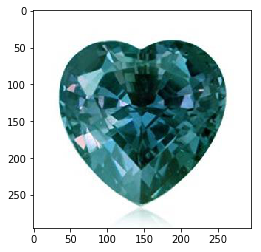

第1个样本,被预测为：Malachite,真实标签为：alexandrite
结束


In [ ]:
label_dic = train_parameters['label_dict']

'''
模型预测
'''
with fluid.dygraph.guard():
    model_dict, _ = fluid.load_dygraph('MyDNN')
    model = MyDNN()
    model.load_dict(model_dict) #加载模型参数
    model.eval() #训练模式
    
    #展示预测图片
    infer_path='data/archive_test/alexandrite_3.jpg'
    img = Image.open(infer_path)
    plt.imshow(img)          #根据数组绘制图像
    plt.show()               #显示图像

    #对预测图片进行预处理
    infer_imgs = []
    infer_imgs.append(load_image(infer_path))
    infer_imgs = np.array(infer_imgs)
   
   
    for i in range(len(infer_imgs)):
        data = infer_imgs[i]
        dy_x_data = np.array(data).astype('float32')
        dy_x_data=dy_x_data[np.newaxis,:, : ,:]
        img = fluid.dygraph.to_variable(dy_x_data)
        out = model(img)
        lab = np.argmax(out.numpy())  #argmax():返回最大数的索引

        print("第{}个样本,被预测为：{},真实标签为：{}".format(i+1,label_dic[str(lab)],infer_path.split('/')[-1].split("_")[0]))
        
print("结束")

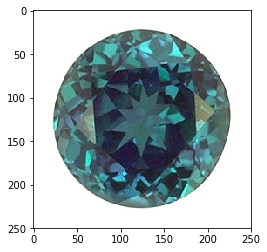

被预测为：Alexandrite,真实标签为：alexandrite


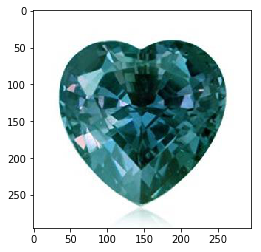

被预测为：Alexandrite,真实标签为：alexandrite


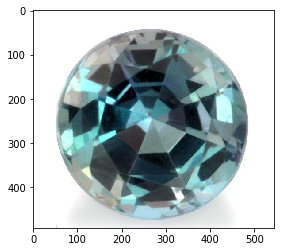

被预测为：Malachite,真实标签为：alexandrite


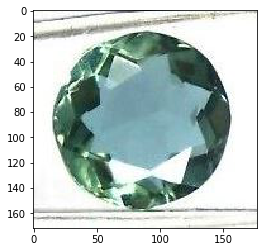

被预测为：Alexandrite,真实标签为：alexandrite
结束


In [ ]:
# 自己写的，对预测目录下的所有文件进行预测
#cp data/dataset/Benitoite/benitoite_1.jpg data/archive_test/
label_dic = train_parameters['label_dict']

'''
模型预测
'''
with fluid.dygraph.guard():
    model_dict, _ = fluid.load_dygraph('MyDNN-best')
    model = MyDNN()
    model.load_dict(model_dict) #加载模型参数
    model.eval() #训练模式
    
    #展示预测图片
    path='data/archive_test'    

    img_paths = os.listdir(path)
    for img_path in img_paths:                                  # 遍历文件夹下的每个图片
        if img_path =='__MACOSX':
            continue    
        #print(img_path)
        name_path = os.path.join(path,img_path) 
        data = load_image(name_path)
        dy_x_data = np.array(data).astype('float32')
        dy_x_data=dy_x_data[np.newaxis,:, : ,:]
        img = fluid.dygraph.to_variable(dy_x_data)
        out = model(img)
        lab = np.argmax(out.numpy())  #argmax():返回最大数的索引 
        #print(img_path.split("_"),len(img_path.split("_")))
        #print(lab)
        img = Image.open(name_path)
        plt.imshow(img)          #根据数组绘制图像
        plt.show()   
        print("被预测为：{},真实标签为：{}".format(label_dic[str(lab)],img_path.split("_")[-2]))
        
print("结束")
